Global Tourism Analysis Part 1
---

In [53]:
# Dependencies and Setup
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import hvplot.pandas

# Import API key
from config import geoapify_key

Cleaning Hotel Bookings Dataset
---

In [36]:
# Reference the file where the CSV is located
hotel_booking_file = Path("Data_Resources/hotel_bookings_dataset.csv")

# Import the date into a Pandas DataFrame
hotel_data = pd.read_csv(hotel_booking_file)

In [37]:
# Remove specified columns from the DataFrame
columns_to_remove = [
    'arrival_date_week_number', 'arrival_date_day_of_month', 'meal',
    'market_segment', 'distribution_channel', 'previous_bookings_not_canceled',
    'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type',
    'agent', 'company', 'days_in_waiting_list', 'customer_type',
    'required_car_parking_spaces', 'total_of_special_requests',
    'reservation_status', 'reservation_status_date', 'lead_time',
    'previous_cancellations'
]

hotel_data = hotel_data.drop(columns=columns_to_remove)
hotel_data.head()

,hotel,is_canceled,arrival_date_year,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,country,is_repeated_guest,adr
0,Resort Hotel,0,2015,July,0,0,2,0.0,0,PRT,0,0.0
1,Resort Hotel,0,2015,July,0,0,2,0.0,0,PRT,0,0.0
2,Resort Hotel,0,2015,July,0,1,1,0.0,0,GBR,0,75.0
3,Resort Hotel,0,2015,July,0,1,1,0.0,0,GBR,0,75.0
4,Resort Hotel,0,2015,July,0,2,2,0.0,0,GBR,0,98.0


In [38]:
# Combine "stays_in_weekend_nights" and "stays_in_week_nights" into a new column "stays_nights"
if 'stays_in_weekend_nights' in hotel_data.columns and 'stays_in_week_nights' in hotel_data.columns:
    hotel_data['stays_nights'] = hotel_data['stays_in_weekend_nights'] + hotel_data['stays_in_week_nights']

# Combine "adults", "children" and "babies" into a new column "number_of_guests"
hotel_data['number_of_guests'] = hotel_data['adults'] + hotel_data['children'] + hotel_data['babies']

# Calculate guest nights
hotel_data['guest_nights'] = hotel_data['stays_nights'] * hotel_data['number_of_guests']

# Get only bookings that were not canceled
hotel_data = hotel_data[hotel_data['is_canceled'] == 0]

# Drop null rows
hotel_data = hotel_data.dropna(how='any')

# Drop unnecessary columns
hotel_data = hotel_data.drop(columns=["stays_in_weekend_nights", "stays_in_week_nights", "adults", "children", "babies", "is_canceled"])

# Display the final DataFrame
hotel_data.head()

,hotel,arrival_date_year,arrival_date_month,country,is_repeated_guest,adr,stays_nights,number_of_guests,guest_nights
0,Resort Hotel,2015,July,PRT,0,0.0,0,2.0,0.0
1,Resort Hotel,2015,July,PRT,0,0.0,0,2.0,0.0
2,Resort Hotel,2015,July,GBR,0,75.0,1,1.0,1.0
3,Resort Hotel,2015,July,GBR,0,75.0,1,1.0,1.0
4,Resort Hotel,2015,July,GBR,0,98.0,2,2.0,4.0


In [39]:
#convert abbreviation to country name in the hotel_data dataframe(code shared by Kathy Nguyen)
country_mapping = {
    'PRT': 'Portugal',
    'GBR': 'United Kingdom',
    'USA': 'United States',
    'ESP': 'Spain',
    'IRL': 'Ireland',
    'FRA': 'France',
    'ROU': 'Romania',
    'NOR': 'Norway',
    'OMN': 'Oman',
    'ARG': 'Argentina',
    'POL': 'Poland',
    'DEU': 'Germany',
    'BEL': 'Belgium',
    'CHE': 'Switzerland',
    'CN': 'China',
    'GRC': 'Greece',
    'ITA': 'Italy',
    'NLD': 'Netherlands',
    'DNK': 'Denmark',
    'RUS': 'Russia',
    'SWE': 'Sweden',
    'AUS': 'Australia',
    'EST': 'Estonia',
    'CZE': 'Czech Republic',
    'BRA': 'Brazil',
    'FIN': 'Finland',
    'MOZ': 'Mozambique',
    'BWA': 'Botswana',
    'LUX': 'Luxembourg',
    'SVN': 'Slovenia',
    'ALB': 'Albania',
    'IND': 'India',
    'CHN': 'China',
    'MEX': 'Mexico',
    'MAR': 'Morocco',
    'UKR': 'Ukraine',
    'SMR': 'San Marino',
    'LVA': 'Latvia',
    'PRI': 'Puerto Rico',
    'SRB': 'Serbia',
    'CHL': 'Chile',
    'AUT': 'Austria',
    'BLR': 'Belarus',
    'LTU': 'Lithuania',
    'TUR': 'Turkey',
    'ZAF': 'South Africa',
    'AGO': 'Angola',
    'ISR': 'Israel',
    'CYM': 'Cayman Islands',
    'ZMB': 'Zambia',
    'CPV': 'Cape Verde',
    'ZWE': 'Zimbabwe',
    'DZA': 'Algeria',
    'KOR': 'South Korea',
    'CRI': 'Costa Rica',
    'HUN': 'Hungary',
    'ARE': 'United Arab Emirates',
    'TUN': 'Tunisia',
    'JAM': 'Jamaica',
    'HRV': 'Croatia',
    'HKG': 'Hong Kong',
    'IRN': 'Iran',
    'GEO': 'Georgia',
    'AND': 'Andorra',
    'GIB': 'Gibraltar',
    'URY': 'Uruguay',
    'JEY': 'Jersey',
    'CAF': 'Central African Republic',
    'CYP': 'Cyprus',
    'COL': 'Colombia',
    'GGY': 'Guernsey',
    'KWT': 'Kuwait',
    'NGA': 'Nigeria',
    'MDV': 'Maldives',
    'VEN': 'Venezuela',
    'SVK': 'Slovakia',
    'FJI': 'Fiji',
    'KAZ': 'Kazakhstan',
    'PAK': 'Pakistan',
    'IDN': 'Indonesia',
    'LBN': 'Lebanon',
    'PHL': 'Philippines',
    'SEN': 'Senegal',
    'SYC': 'Seychelles',
    'AZE': 'Azerbaijan',
    'BHR': 'Bahrain',
    'NZL': 'New Zealand',
    'THA': 'Thailand',
    'DOM': 'Dominican Republic',
    'MKD': 'North Macedonia',
    'MYS': 'Malaysia',
    'ARM': 'Armenia',
    'JPN': 'Japan',
    'LKA': 'Sri Lanka',
    'CUB': 'Cuba',
    'CMR': 'Cameroon',
    'BIH': 'Bosnia and Herzegovina',
    'MUS': 'Mauritius',
    'COM': 'Comoros',
    'SUR': 'Suriname',
    'UGA': 'Uganda',
    'BGR': 'Bulgaria',
    'CIV': 'Ivory Coast',
    'JOR': 'Jordan',
    'SYR': 'Syria',
    'SGP': 'Singapore',
    'BDI': 'Burundi',
    'SAU': 'Saudi Arabia',
    'VNM': 'Vietnam',
    'PLW': 'Palau',
    'QAT': 'Qatar',
    'EGY': 'Egypt',
    'PER': 'Peru',
    'MLT': 'Malta',
    'MWI': 'Malawi',
    'ECU': 'Ecuador',
    'MDG': 'Madagascar',
    'ISL': 'Iceland',
    'UZB': 'Uzbekistan',
    'NPL': 'Nepal',
    'BHS': 'Bahamas',
    'MAC': 'Macau',
    'TGO': 'Togo',
    'TWN': 'Taiwan',
    'DJI': 'Djibouti',
    'STP': 'Sao Tome and Principe',
    'KNA': 'Saint Kitts and Nevis',
    'ETH': 'Ethiopia',
    'IRQ': 'Iraq',
    'HND': 'Honduras',
    'RWA': 'Rwanda',
    'KHM': 'Cambodia',
    'MCO': 'Monaco',
    'BGD': 'Bangladesh',
    'IMN': 'Isle of Man',
    'TJK': 'Tajikistan',
    'NIC': 'Nicaragua',
    'BEN': 'Benin',
    'VGB': 'British Virgin Islands',
    'TZA': 'Tanzania',
    'GAB': 'Gabon',
    'GHA': 'Ghana',
    'TMP': 'Timor-Leste',
    'GLP': 'Guadeloupe',
    'KEN': 'Kenya',
    'LIE': 'Liechtenstein',
    'GNB': 'Guinea-Bissau',
    'MNE': 'Montenegro',
    'UMI': 'United States Minor Outlying Islands',
    'MYT': 'Mayotte',
    'FRO': 'Faroe Islands',
    'MMR': 'Myanmar',
    'PAN': 'Panama',
    'BFA': 'Burkina Faso',
    'LBY': 'Libya',
    'MLI': 'Mali',
    'NAM': 'Namibia',
    'BOL': 'Bolivia',
    'PRY': 'Paraguay',
    'BRB': 'Barbados',
    'ABW': 'Aruba',
    'AIA': 'Anguilla',
    'SLV': 'El Salvador',
    'DMA': 'Dominica',
    'PYF': 'French Polynesia',
    'GUY': 'Guyana',
    'LCA': 'Saint Lucia',
    'ATA': 'Antarctica',
    'GTM': 'Guatemala',
    'ASM': 'American Samoa',
    'MRT': 'Mauritania',
    'NCL': 'New Caledonia',
    'KIR': 'Kiribati',
    'SDN': 'Sudan',
    'ATF': 'French Southern Territories',
    'SLE': 'Sierra Leone',
    'LAO': 'Laos',
}

# Replace initials with full country names
hotel_data['country'] = hotel_data['country'].replace(country_mapping)
hotel_data.head()

,hotel,arrival_date_year,arrival_date_month,country,is_repeated_guest,adr,stays_nights,number_of_guests,guest_nights
0,Resort Hotel,2015,July,Portugal,0,0.0,0,2.0,0.0
1,Resort Hotel,2015,July,Portugal,0,0.0,0,2.0,0.0
2,Resort Hotel,2015,July,United Kingdom,0,75.0,1,1.0,1.0
3,Resort Hotel,2015,July,United Kingdom,0,75.0,1,1.0,1.0
4,Resort Hotel,2015,July,United Kingdom,0,98.0,2,2.0,4.0


Question #1: Popular Destinations - What are the most popular destinations?
--- 

3 key metrics: Total Guests, Total Guest Nights, Average Stay

Top Destinations by Total Guests: Total Guests represents the raw number of visitors to each country, giving us a straightforward understanding of the countries attracting the most tourists based on the volume of bookings.
Key Insights:

Portugal (PRT) tops the list, which indicates it is drawing the largest number of tourists overall. This could be due to the country's increasing popularity in recent years, bolstered by cultural and historical appeal, affordable travel options, and increasing international awareness. United Kingdom (GBR) follows closely, which might indicate its strong appeal due to cultural landmarks, proximity to other European countries, and its role as a major international hub. France (FRA), Spain (ESP), and Germany (DEU) make up the next few spots, which is consistent with their status as major global tourist destinations, benefiting from rich cultural offerings, major cities, and significant infrastructure. Key Metric Impact: A high number of visitors is often a strong indicator of a country's tourism infrastructure, cultural offerings, and global appeal. However, Total Guests alone doesn’t necessarily capture the full picture of a destination's tourism appeal—this is where Total Guest Nights and Average Stay come into play.

Top Destinations by Total Guest Nights: Total Guest Nights combines the number of guests with the length of their stay. This metric provides a fuller picture of a destination’s tourism impact, as it not only captures how many tourists visit but also how long they stay, which can have a significant effect on local economies (e.g., spending on accommodations, food, etc.).
Key Insights:

Portugal still leads the chart in Total Guest Nights due to a high number of visitors, supported by a relatively short average stay. However, United Kingdom (GBR) follows closely despite having fewer guests overall. This is because the average stay in the UK is much longer (4.98 nights) compared to Portugal's 2.51 nights. This shows that while Portugal is more popular in terms of sheer numbers, the UK benefits from longer stays, leading to a similar overall tourism impact in terms of guest nights. France and Germany also feature highly, highlighting their sustained appeal across both dimensions: the number of guests and the average length of stay. Spain, while having a high volume of visitors, has relatively shorter average stays, which affects its total guest nights. Key Metric Impact: A high total number of guest nights indicates that a destination is attracting not only a lot of tourists but also encouraging them to stay for longer periods. Destinations with longer stays like the UK can sustain a high guest night volume even with fewer visitors compared to countries like Portugal.

Top Destinations by Average Stay (Nights): This metric is important as it reveals which destinations attract tourists who tend to stay longer, suggesting a different kind of appeal, possibly to a more niche or luxury market. Longer stays might indicate tourists who are seeking a more immersive or relaxed experience.
Key Insights:

Ireland (IRL) has the longest average stay at 5.27 nights, which suggests it might be a destination catering to tourists seeking a more leisurely and relaxed experience. It could be appealing to those interested in scenic, slower-paced travel, or to those visiting less-touristy, rural destinations. Norway (NOR) and Romania (ROU) also show relatively high average stays (4.20 and 4.38 nights, respectively), which again could indicate more specialized or niche tourism—such as nature tourism in Norway or cultural/historical tourism in Romania. In contrast, France and Spain have shorter average stays (around 3.5 nights), which might suggest these destinations are popular for shorter holidays or city breaks. Key Metric Impact: A longer average stay might indicate that tourists are investing more time in exploring the destination, perhaps for a more immersive or niche experience. This metric is valuable for understanding tourism in areas that are not the top-of-mind but cater to a different type of traveler.

Total Guest Nights per Country: This is essentially a combination of both the number of guests and their average length of stay. It provides a comprehensive view of the overall tourism demand for a destination.
Key Insights:

Portugal (101,356 guest nights) and United Kingdom (96,277 guest nights) are at the top, showing that both countries are major tourism hubs not only in terms of total visitors but also in the length of stay. Germany and France also show high total guest nights, indicating their steady global appeal. Smaller countries with higher average stays like Norway, Romania, and Israel may not top the chart for total guest nights but still maintain significant tourism engagement based on their high-quality, specialized offerings. Key Metric Impact: This metric highlights overall tourism demand and helps identify countries that attract both a high number of visitors and those that are engaging tourists for longer periods of time. It’s a powerful indicator of how tourism is impacting each country's economy and infrastructure.

Observations from the Map: Looking at the geographical spread of these countries on a map allows for the identification of clusters of popular destinations.
Western Europe Dominance: As expected, Western European countries like Portugal, United Kingdom, France, Germany, and Spain dominate in terms of guest nights. This suggests that these regions have well-established tourism industries with strong international appeal.

Other Regions: Countries like China and Russia show up in terms of guest nights, although their figures are somewhat lower. Their geographical spread, however, highlights that tourism is not just concentrated in Europe—there are also growing tourist flows from regions like Asia and Eastern Europe.

Smaller but Specialized Destinations: Ireland, Norway, Romania, and Israel are examples of countries with high average stays but fewer total guest nights. This points to a different kind of tourism model, possibly catering to niche markets (e.g., adventure tourism, historical tourism, etc.).

Conclusion: The popularity of tourist destinations is driven not just by the number of visitors, but also by factors like the average length of stay and total guest nights. While Portugal has the highest number of visitors, its shorter average stay keeps it at a comparable level to other countries like the United Kingdom, where longer stays balance out the lower number of visitors. Countries like Ireland and Norway may not attract as many visitors overall, but their high average stay indicates that their tourism industry is catering to travelers seeking more immersive experiences.

The popularity of a destination is, therefore, a combination of these factors, and understanding the balance between total guests and average stay can provide deeper insights into the nature of tourism in each country.

Further Insights to Explore: Trip Duration Variability: Combining this analysis with insights from Miguel on Trip Duration Variability would add another layer of understanding, as higher duration of trips may correlate with longer stays which could further affect a destination's popularity.

#Statistical analysis & Data Visualization
---

In [40]:
# Get total visitors and average stays
hotel_data_summary = hotel_data.groupby("country").agg(
    total_guests=("number_of_guests", "sum"),
    average_stay=("stays_nights", "mean"),
    total_guest_nights=("guest_nights", "sum"),
).reset_index()
hotel_data_summary

,country,total_guests,average_stay,total_guest_nights
0,Albania,18.0,3.200000,59.0
1,Algeria,136.0,3.475610,498.0
2,American Samoa,2.0,1.000000,2.0
3,Andorra,7.0,4.500000,30.0
4,Angola,284.0,3.961783,1142.0
...,...,...,...,...
159,Uzbekistan,3.0,1.000000,3.0
160,Venezuela,28.0,2.785714,78.0
161,Vietnam,13.0,2.666667,36.0
162,Zambia,4.0,6.000000,24.0


In [41]:
# Top 20 countries with highest guests, average_stay_nights, total_guests_nights
top_popularity_by_guests = hotel_data_summary.sort_values(by="total_guests", ascending=False).head(20)
print(top_popularity_by_guests)

            country  total_guests  average_stay  total_guest_nights
118        Portugal       37670.0      2.508519            101356.0
156  United Kingdom       19258.0      4.979434             96277.0
50           France       17299.0      3.456550             60881.0
138           Spain       13213.0      2.976686             40979.0
55          Germany       11659.0      3.485582             41212.0
69          Ireland        5102.0      5.267794             27177.0
71            Italy        4894.0      3.180025             15854.0
18          Belgium        3855.0      3.668094             14324.0
104     Netherlands        3374.0      3.679091             12623.0
157   United States        3212.0      2.639098              8279.0
31            China        3169.0      3.314981             10601.0
22           Brazil        3000.0      3.169297              9581.0
143     Switzerland        2680.0      3.526114              9550.0
11          Austria        2014.0      3.647628 

In [42]:
# Replace initials with full country names
top_popularity_by_guests['country_name'] = top_popularity_by_guests['country'].replace(country_mapping)

top_popularity_by_guests

,country,total_guests,average_stay,total_guest_nights,country_name
118,Portugal,37670.0,2.508519,101356.0,Portugal
156,United Kingdom,19258.0,4.979434,96277.0,United Kingdom
50,France,17299.0,3.456550,60881.0,France
138,Spain,13213.0,2.976686,40979.0,Spain
55,Germany,11659.0,3.485582,41212.0,Germany
69,Ireland,5102.0,5.267794,27177.0,Ireland
71,Italy,4894.0,3.180025,15854.0,Italy
18,Belgium,3855.0,3.668094,14324.0,Belgium
104,Netherlands,3374.0,3.679091,12623.0,Netherlands
157,United States,3212.0,2.639098,8279.0,United States


In [43]:
# Top 20 countries with average_stay, total_guests_nights
top_popularity_by_total_guest_nights = top_popularity_by_guests.sort_values(by="total_guest_nights", ascending=False).head(20)
top_popularity_by_average_stay = top_popularity_by_guests.sort_values(by="average_stay", ascending=False).head(20)

print(top_popularity_by_total_guest_nights)
print(top_popularity_by_average_stay)

            country  total_guests  average_stay  total_guest_nights  \
118        Portugal       37670.0      2.508519            101356.0   
156  United Kingdom       19258.0      4.979434             96277.0   
50           France       17299.0      3.456550             60881.0   
55          Germany       11659.0      3.485582             41212.0   
138           Spain       13213.0      2.976686             40979.0   
69          Ireland        5102.0      5.267794             27177.0   
71            Italy        4894.0      3.180025             15854.0   
18          Belgium        3855.0      3.668094             14324.0   
104     Netherlands        3374.0      3.679091             12623.0   
31            China        3169.0      3.314981             10601.0   
22           Brazil        3000.0      3.169297              9581.0   
143     Switzerland        2680.0      3.526114              9550.0   
157   United States        3212.0      2.639098              8279.0   
11    

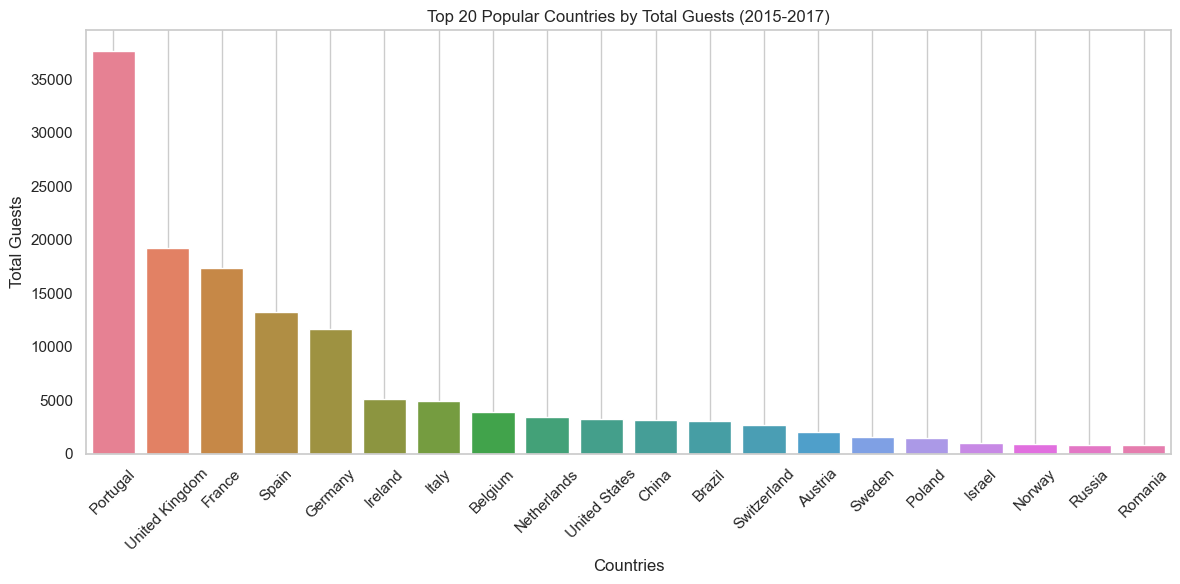

In [44]:
# Chart showing Top 20 Popular Countries by Total Guests

plt.figure(figsize=(12, 6))
sns.barplot(data=top_popularity_by_guests, x='country_name', y='total_guests', hue='country_name')
plt.title('Top 20 Popular Countries by Total Guests (2015-2017)')
plt.xlabel('Countries')
plt.ylabel('Total Guests')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

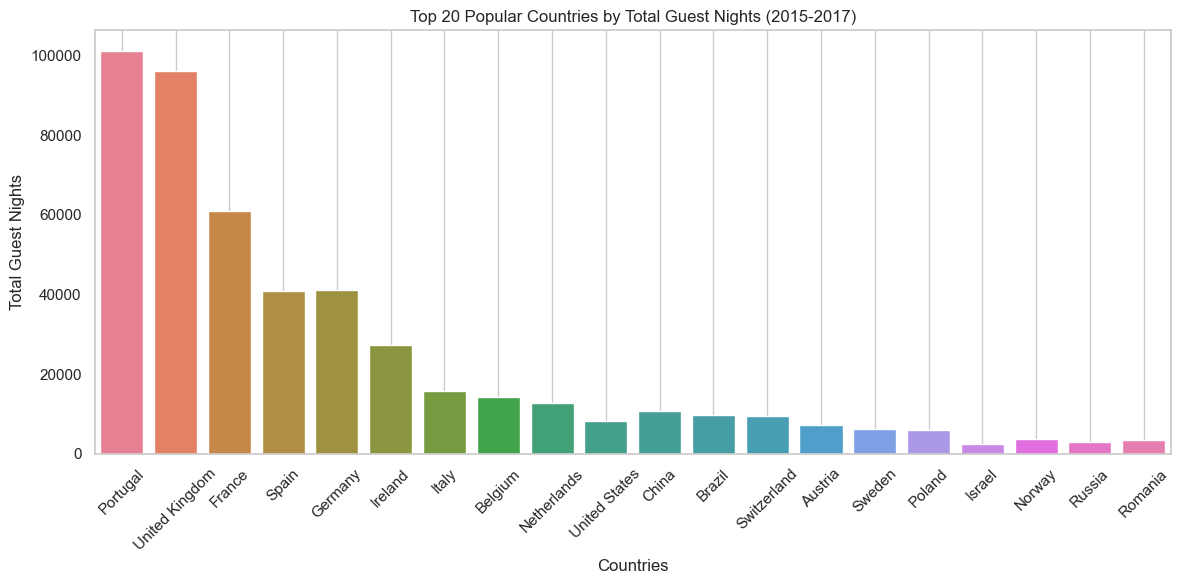

In [45]:
# Chart showing Top 20 Popular Countries by Total Guest Nights

plt.figure(figsize=(12, 6))
sns.barplot(data=top_popularity_by_guests, x='country_name', y='total_guest_nights', hue='country_name')
plt.title('Top 20 Popular Countries by Total Guest Nights (2015-2017)')
plt.xlabel('Countries')
plt.ylabel('Total Guest Nights')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

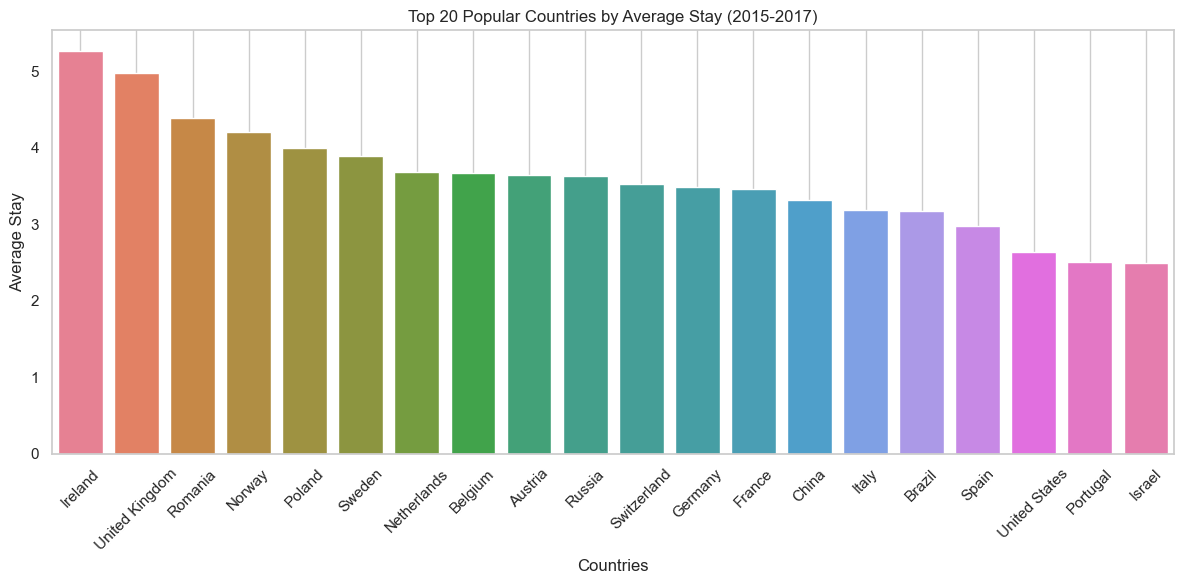

In [46]:
# Chart showing Top 20 Countries by Average Stay

plt.figure(figsize=(12, 6))
sns.barplot(data=top_popularity_by_average_stay, x='country_name', y='average_stay', hue='country_name')
plt.title('Top 20 Popular Countries by Average Stay (2015-2017)')
plt.xlabel('Countries')
plt.ylabel('Average Stay')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

plt.show()

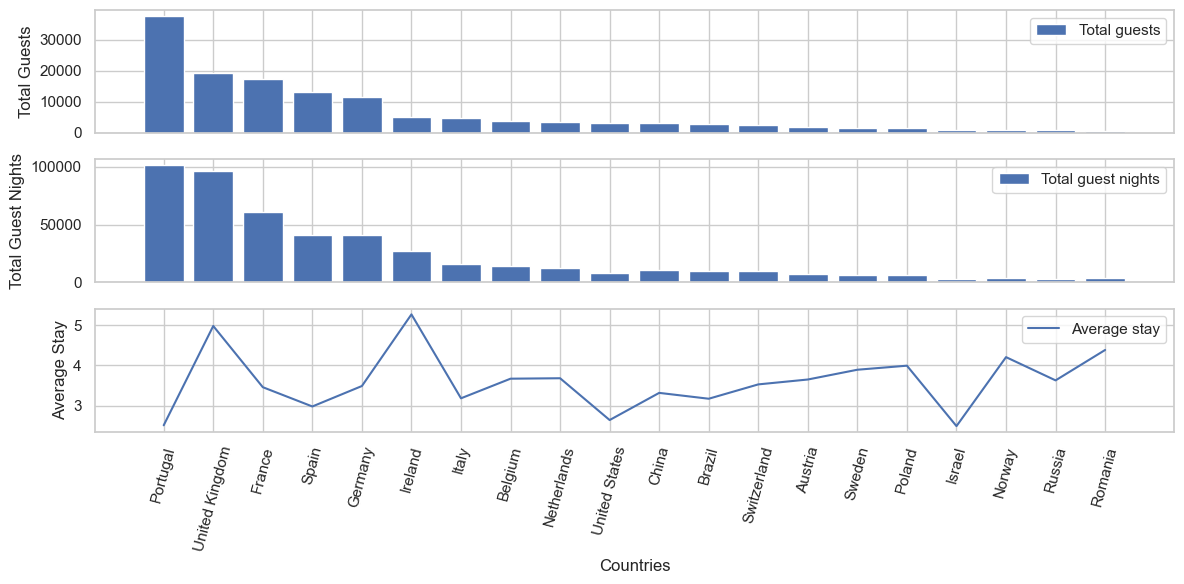

In [47]:
# Create a figure and subplots
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(12, 6))

# Plot data on the individual axes
ax[0].bar(top_popularity_by_guests['country_name'], top_popularity_by_guests['total_guests'], label='Total guests')
ax[0].set_ylabel('Total Guests')
ax[0].legend()

ax[1].bar(top_popularity_by_guests['country_name'], top_popularity_by_guests['total_guest_nights'], label='Total guest nights')
ax[1].set_ylabel('Total Guest Nights')
ax[1].legend()

ax[2].plot(top_popularity_by_guests['country_name'], top_popularity_by_guests['average_stay'], label='Average stay')
ax[2].set_ylabel('Average Stay')
ax[2].set_xlabel('Countries')
ax[2].legend()
plt.xticks(rotation=75)
sns.set(style="whitegrid")

# Display the plot
plt.tight_layout()


plt.show()

In [48]:
# Define the API parameters
params = {
    "apiKey":geoapify_key,
    "format":"json"
}

# Set the base URL
base_url = "https://api.geoapify.com/v1/geocode/search"

In [51]:
# Print a message to follow up the airport search
print("Starting country search")

# Loop through the top_popularity_by_guests DataFrame and search coordinates for country
for index, row in top_popularity_by_guests.iterrows():

    # Get the country to the string so geoapify finds the correct country
    country_name = row["country_name"]

    # Add the current city to the parameters
    params["text"] = f"{country_name}"

    # Make the API request
    response = requests.get(base_url, params=params)
    
    # Convert response to JSON
    response = response.json()

    # Extract latitude and longitude
    top_popularity_by_guests.loc[index, "Lat"] = response["results"][0]["lat"]
    top_popularity_by_guests.loc[index, "Lon"] = response["results"][0]["lon"]
    top_popularity_by_guests.loc[index, "country_name"] = response["results"][0]["country"]
    # Log the search results
    print(f"Coordinates for {country_name} fetched...")

# Display sample data to confirm that the coordinates appear
top_popularity_by_guests

Starting country search
Coordinates for Portugal fetched...
Coordinates for United Kingdom fetched...
Coordinates for France fetched...
Coordinates for Spain fetched...
Coordinates for Germany fetched...
Coordinates for Ireland fetched...
Coordinates for Italy fetched...
Coordinates for Belgium fetched...
Coordinates for Netherlands fetched...
Coordinates for United States fetched...
Coordinates for China fetched...
Coordinates for Brazil fetched...
Coordinates for Switzerland fetched...
Coordinates for Austria fetched...
Coordinates for Sweden fetched...
Coordinates for Poland fetched...
Coordinates for Israel fetched...
Coordinates for Norway fetched...
Coordinates for Russia fetched...
Coordinates for Romania fetched...


,country,total_guests,average_stay,total_guest_nights,country_name,Lat,Lon
118,Portugal,37670.0,2.508519,101356.0,Portugal,39.662165,-8.135352
156,United Kingdom,19258.0,4.979434,96277.0,United Kingdom,54.702354,-3.276575
50,France,17299.0,3.456550,60881.0,France,46.603354,1.888334
138,Spain,13213.0,2.976686,40979.0,Spain,39.326068,-4.837979
55,Germany,11659.0,3.485582,41212.0,Germany,51.163818,10.447831
69,Ireland,5102.0,5.267794,27177.0,Ireland,52.865196,-7.979460
71,Italy,4894.0,3.180025,15854.0,Italy,42.638426,12.674297
18,Belgium,3855.0,3.668094,14324.0,Belgium,50.640281,4.666715
104,Netherlands,3374.0,3.679091,12623.0,Netherlands,52.243498,5.634323
157,United States,3212.0,2.639098,8279.0,United States of America,39.783730,-100.445882


In [54]:
# Configure the map of countries by total guest nights
map_popularity_total_guest_night = top_popularity_by_guests.hvplot.points(
    "Lon",
    "Lat",
    geo = True,
    tiles = "EsriNatGeo",
    frame_width = 700,
    frame_height = 500,
    size = "total_guest_nights",
    scale = 0.08,
    color = "country_name",
    hover_cols=['Lon','Lat','country_name', 'total_guests', 'total_guest_nights','average_stay_nights']
)
# Display the map plot
map_popularity_total_guest_night

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Lon,Lat]   (country_name,total_guest_nights,total_guests)

Question #4: Seasonal Tourism Trends - Are there seasonal trends in tourism?
---


Seasonal patterns:
All seasons recorded an increase in total number of days from 2015 to 2017.

Differences across seasons:
All the seasons have either been appreciating or stable regarding the total number of stays.

Changes over time:
Summer seasons recorded massive increase in total days of stay over the 3-year period ranging from 25,140 to 61,801.



#Statistical Analysis & Data Visualization
---

In [70]:
# Ensure seasons are mapped correctly
seasons = {
    'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
    'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
    'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
    'September': 'Autumn', 'October': 'Autumn', 'November': 'Autumn'
}

# Add a 'Season' column
hotel_data['Season'] = hotel_data['arrival_date_month'].map(seasons)

# Group by Year and Season
seasonal_trends_yearly = hotel_data.groupby(['arrival_date_year', 'Season']).agg({
    'adr': 'mean',
    'stays_nights': 'sum'
}).reset_index()

# Ensure seasons are in correct order
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
seasonal_trends_yearly['Season'] = pd.Categorical(
    seasonal_trends_yearly['Season'], 
    categories=season_order, 
    ordered=True
)

# Sort data for plotting
seasonal_trends_yearly = seasonal_trends_yearly.sort_values(['arrival_date_year', 'Season'])

# Display the calculated trends
seasonal_trends_yearly

,arrival_date_year,Season,adr,stays_nights
2,2015,Winter,71.562673,5682
1,2015,Summer,112.355541,15438
0,2015,Autumn,81.931099,26835
6,2016,Winter,73.310579,18757
4,2016,Spring,85.713974,32337
5,2016,Summer,125.160030,35674
3,2016,Autumn,96.673344,32427
9,2017,Winter,73.596421,15760
7,2017,Spring,102.090610,34719
8,2017,Summer,141.715644,36343


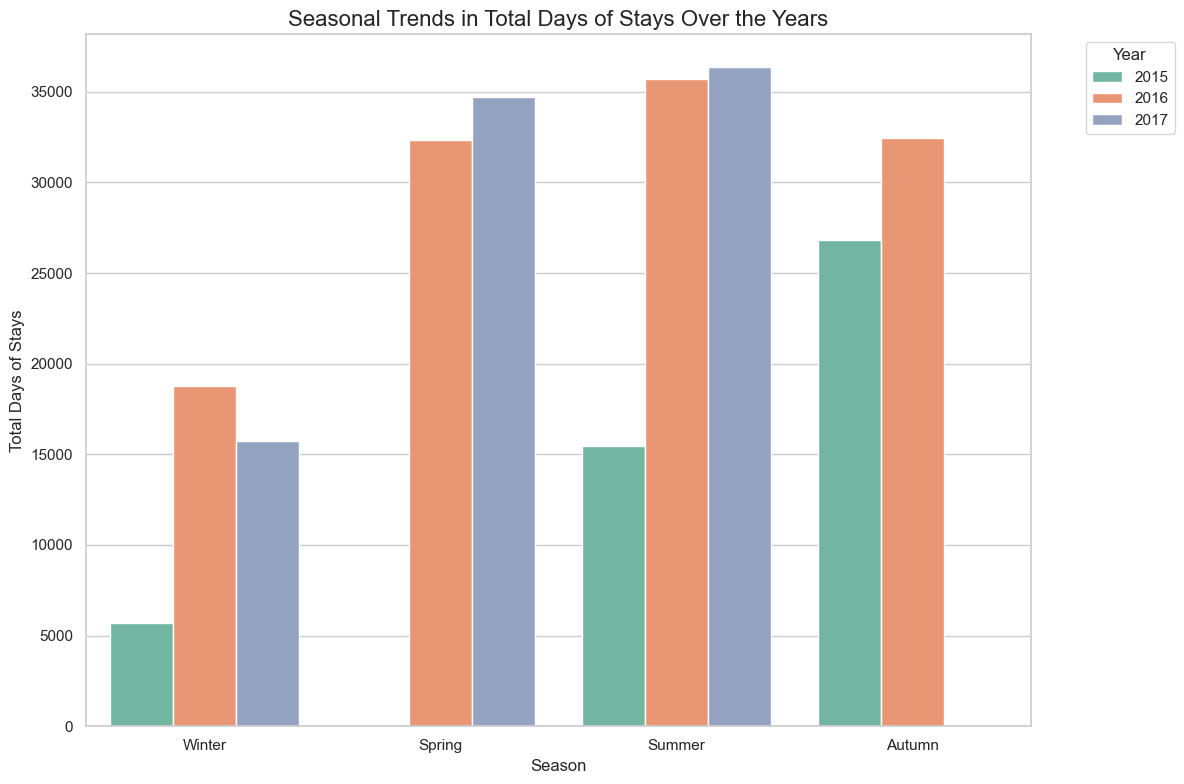

In [75]:
# Bar plot for seasonal total stays over years
plt.figure(figsize=(12, 8))
sns.barplot(
    data=seasonal_trends_yearly, 
    x='Season', 
    y='stays_nights', 
    hue='arrival_date_year', 
    palette='Set2'
)

# Add labels and title
plt.title("Seasonal Trends in Total Days of Stays Over the Years", fontsize=16)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Total Days of Stays", fontsize=12)
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Question #5: Hotel Price Fluctuations - How do hotel prices fluctuate over time in different regions?
---

The analysis of hotel booking data from 2015 to 2017 reveals significant fluctuations in hotel prices over time, influenced by several factors including seasonal changes, hotel type, and geographic region. Here's a detailed breakdown of the findings:

In our hotel pricing analysis, filtering by Average Daily Rates (ADRs) revealed key insights. An anomaly in March showed a 5400 ADR from Portugal, far above the average of 109.97. To reflect accurate trends, we focused on the mean ADRs, highlighting July and August as peak months due to high travel demand. These trends illustrate seasonal pricing variations across regions.

In analyzing ADR trends in relationship to city hotels versus resorts: City hotels maintain stable ADRs throughout the year, peaking from April to July due to increased travel. Resort hotels, however, see significant ADR spikes in July and August, driven by summer leisure demand. 

In the top five countries—Morocco, Portugal, Spain, the UK, and Italy—summer is the peak season for the mean ADRs, with Morocco leading at 175.21, followed by Spain and Italy. In spring, Italy leads with 104.39, followed by Morocco. Fall season Morocco has the highest mean ADR with 121.66, followed by Italy and Spain. Winter shows a drop in ADRs across all countries, with Italy maintaining the highest rates in the winter. 


#Statistical Analysis & Data Visualization
---

In [85]:
#Mean values on Average Daily Rate versus Months (2015-2017)

# Define the desired order of the months
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

# Convert 'arrival_month' to a categorical type with the specified order
hotel_data['arrival_date_month'] = pd.Categorical(hotel_data['arrival_date_month'], categories=month_order, ordered=True)

# Group data by 'arrival_date_month' and calculate the average daily rate
average_rate_by_month = hotel_data.groupby('arrival_date_month')['adr'].mean().reset_index()

# Rename the columns for clarity
average_rate_by_month.columns = ['arrival_date_month', 'adr']


# Display the resulting DataFrame
average_rate_by_month

/var/folders/3z/9w8jmp553xbf4bc22cm_w0100000gn/T/ipykernel_14042/4177118193.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_rate_by_month = hotel_data.groupby('arrival_date_month')['adr'].mean().reset_index()


,arrival_date_month,adr
0,January,67.346910
1,February,72.744330
2,March,77.631906
3,April,98.104496
4,May,104.917406
5,June,114.651186
6,July,129.324631
7,August,142.051660
8,September,107.278059
9,October,87.059600


/var/folders/3z/9w8jmp553xbf4bc22cm_w0100000gn/T/ipykernel_14042/3040798244.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


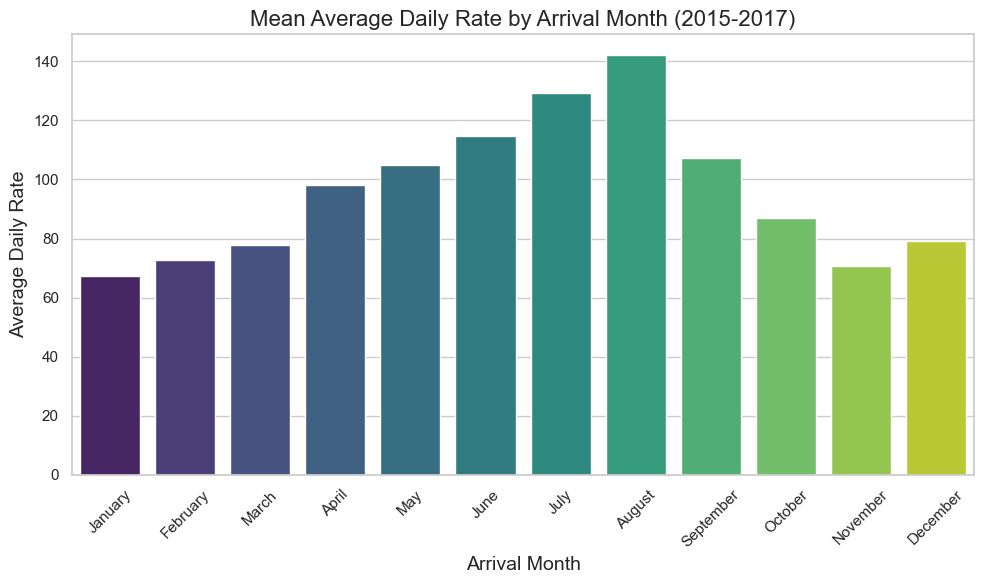

In [83]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a bar plot for average daily rates by arrival month
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(
    data=average_rate_by_month,
    x='arrival_date_month',
    y='adr',
    palette='viridis'
)

# Add titles and labels
plt.title('Mean Average Daily Rate by Arrival Month (2015-2017)', fontsize=16)
plt.xlabel('Arrival Month', fontsize=14)
plt.ylabel('Average Daily Rate', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

In [86]:
#Mean ADRs on Hotel types over time

# Ensure 'Arrival Month' is already categorized in the desired order
hotel_data['arrival_date_month'] = pd.Categorical(hotel_data['arrival_date_month'], categories=month_order, ordered=True)

# Group by hotel type and arrival month, then calculate the average daily rate
average_rate_by_hotel_month_mean = hotel_data.groupby(['hotel', 'arrival_date_month'])['adr'].mean().reset_index()

# Rename columns for clarity
average_rate_by_hotel_month_mean.columns = ['hotel', 'arrival_date_month', 'adr']

# Display the resulting DataFrame
print(average_rate_by_hotel_month_mean)

           hotel arrival_date_month         adr
0     City Hotel            January   82.160634
1     City Hotel           February   86.183025
2     City Hotel              March   90.170722
3     City Hotel              April  111.856824
4     City Hotel                May  120.445842
5     City Hotel               June  117.702075
6     City Hotel               July  115.563810
7     City Hotel             August  118.412083
8     City Hotel          September  112.598452
9     City Hotel            October  101.745956
10    City Hotel           November   86.499714
11    City Hotel           December   87.856764
12  Resort Hotel            January   48.940000
13  Resort Hotel           February   54.468180
14  Resort Hotel              March   57.362727
15  Resort Hotel              April   76.176140
16  Resort Hotel                May   76.734804
17  Resort Hotel               June  108.079808
18  Resort Hotel               July  150.483553
19  Resort Hotel             August  181

/var/folders/3z/9w8jmp553xbf4bc22cm_w0100000gn/T/ipykernel_14042/698178294.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_rate_by_hotel_month_mean = hotel_data.groupby(['hotel', 'arrival_date_month'])['adr'].mean().reset_index()


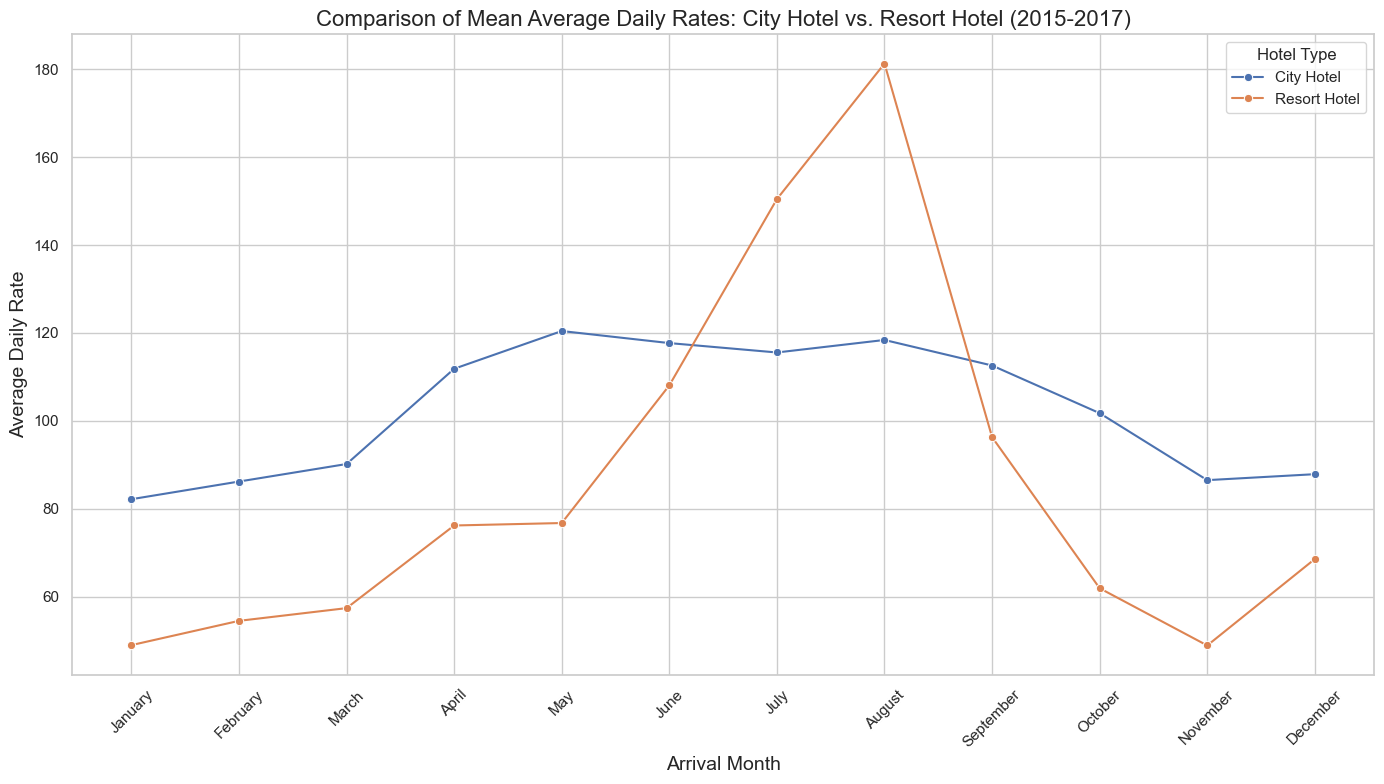

In [88]:
# Filter the data for city hotels and resort hotels
data_mean = average_rate_by_hotel_month_mean[average_rate_by_hotel_month_mean['hotel'].isin(['City Hotel', 'Resort Hotel'])]

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a line plot for average daily rates by hotel type and arrival month
plt.figure(figsize=(14, 8))
line_plot = sns.lineplot(
    data=data_mean,
    x='arrival_date_month',
    y='adr',
    hue='hotel',
    marker='o'  # Adds markers to each data point
)

# Add titles and labels
plt.title('Comparison of Mean Average Daily Rates: City Hotel vs. Resort Hotel (2015-2017)', fontsize=16)
plt.xlabel('Arrival Month', fontsize=14)
plt.ylabel('Average Daily Rate', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the legend
plt.legend(title='Hotel Type')

# Show the plot
plt.tight_layout()
plt.show()

In [99]:
#Seasons by Top 5 Countries highest mean ADRs:

# Define the order of the months and map them to seasons
month_to_season = {
    "January": "Winter", "February": "Spring", "March": "Spring",
    "April": "Spring", "May": "Summer", "June": "Summer",
    "July": "Summer", "August": "Summer", "September": "Fall",
    "October": "Fall", "November": "Winter", "December": "Winter"
}

# Add a 'Season' column to the DataFrame
hotel_data['Season'] = hotel_data['arrival_date_month'].map(month_to_season)

# Group by Country to calculate the overall average ADR
overall_avg_adr_by_country = hotel_data.groupby('country')['adr'].max().reset_index()

# Sort and select the top 5 countries by overall ADR
top_5_countries = overall_avg_adr_by_country.sort_values(by='adr', ascending=False).head(5)['country']

# Filter the original DataFrame to include only the top 5 countries
filtered_data = hotel_data[hotel_data['country'].isin(top_5_countries)]

# Group by Season and Country, then calculate the average ADR for the filtered data
avg_adr_by_season_and_country = filtered_data.groupby(['Season', 'country'])['adr'].mean().reset_index()
avg_adr_by_season_and_country

,Season,country,adr
0,Fall,Italy,114.185000
1,Fall,Morocco,116.641538
2,Fall,Portugal,90.103775
3,Fall,Spain,103.284183
4,Fall,United Kingdom,83.291988
5,Spring,Italy,101.661596
6,Spring,Morocco,97.312453
7,Spring,Portugal,70.408785
8,Spring,Spain,90.064617
9,Spring,United Kingdom,73.477003


/var/folders/3z/9w8jmp553xbf4bc22cm_w0100000gn/T/ipykernel_14042/563331446.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=avg_adr_by_season_and_country, x='Season', y='adr', hue='country', marker='o', ci=None, palette='tab10')


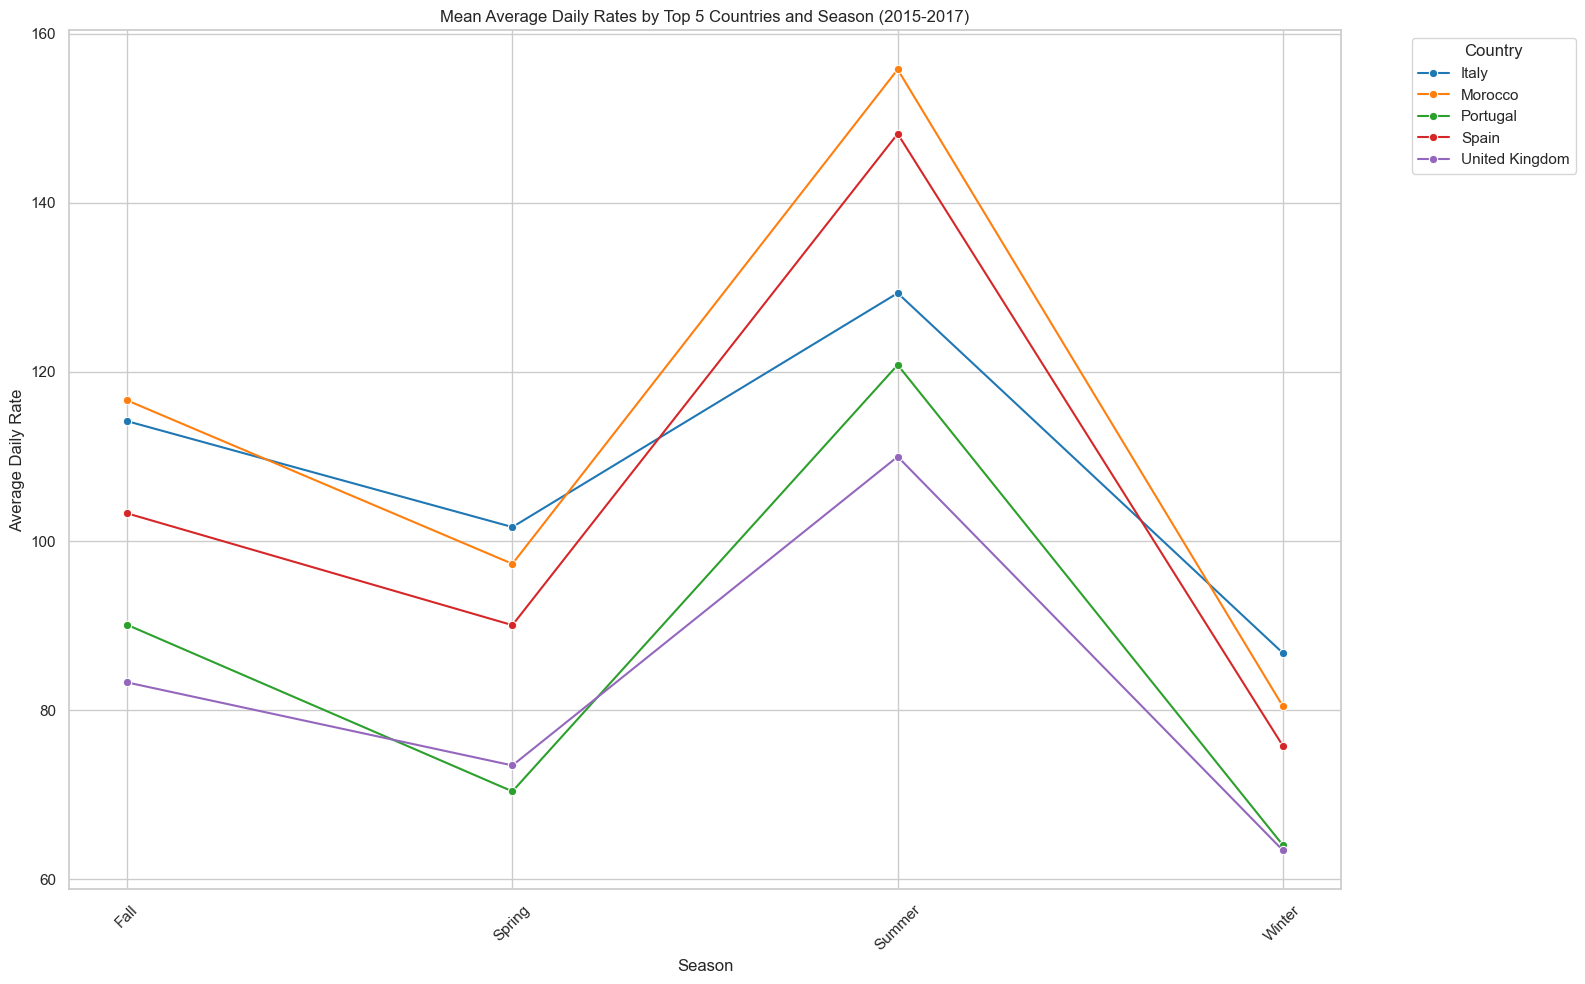

In [101]:
# Plot the results
plt.figure(figsize=(16, 10))
sns.lineplot(data=avg_adr_by_season_and_country, x='Season', y='adr', hue='country', marker='o', ci=None, palette='tab10')
plt.title('Mean Average Daily Rates by Top 5 Countries and Season (2015-2017)')
plt.xlabel('Season')
plt.ylabel('Average Daily Rate')
plt.xticks(rotation=45)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()